In [ ]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from skimage.feature import peak_local_max, peak_local_min
from skimage.filters import gaussian
from ultralytics import SAM
import os
import glob


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/tom_hill_joltsynsor_com/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [81]:

def find_filtered_maxima(mask, score_threshold=2.0, min_distance=20):
    """Find local maxima, then filter by score"""
    # Find all local maxima
    coordinates = peak_local_max(mask, min_distance=min_distance)

    # Filter by score threshold
    filtered_points = []
    for coord in coordinates:
        score = mask[coord[0], coord[1]]
        if score >= score_threshold:
            filtered_points.append((int(coord[1]), int(coord[0])))  # (x, y) format

    return np.array(filtered_points)



# Usage
image = "merged_scan_2_092_perspective"

mask = np.load(f"raw_anomaly_masks/{image}_mask.npy")
original_image_path = f"perspective_dataset/anomaly/{image}.png"
original_image = cv2.imread(original_image_path)
maxima = find_filtered_maxima(mask, score_threshold=2.5, min_distance=10)

print(f"Found {len(maxima)} high-score local maxima")


Found 12 high-score local maxima


In [82]:
# cluster hotspots

from sklearn.cluster import DBSCAN

eps = 100 #pixels
min_samples = 1

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
maxima_labels = dbscan.fit_predict(maxima)

unique_maxima_labels = np.unique(maxima_labels)

maxima_centroids = []
for label in unique_maxima_labels:
    cluster_points = maxima[maxima_labels == label]
    centroid = np.mean(cluster_points, axis=0)
    maxima_centroids.append(centroid)

maxima_centroids = np.array(maxima_centroids)

print(maxima_centroids)


[[      146.6        58.6]
 [        473          72]
 [      463.5         355]
 [        227         467]
 [       79.5       461.5]
 [        366          39]]


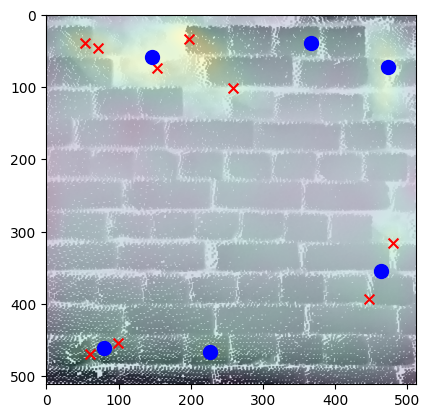

<function matplotlib.pyplot.show(close=None, block=None)>

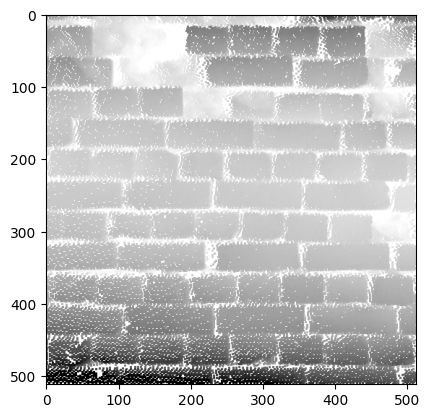

In [83]:
plt.rcParams['image.origin'] = 'upper'

plt.scatter(maxima[:, 0], maxima[:, 1], color='red', marker='x', s=50)
plt.scatter(maxima_centroids[:, 0], maxima_centroids[:, 1], color='blue', marker='o', s=100)

plt.imshow(mask, alpha=0.7)
plt.imshow(original_image, alpha=0.7)
plt.show()

plt.imshow(original_image)
plt.show

In [39]:
from ultralytics import SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt

sam_model = SAM('sam2_l.pt')

100%|██████████| 428M/428M [00:05<00:00, 76.7MB/s] 


In [84]:
def run_sam_on_hotspots(image_path, maxima_points):
    """Simple function to run SAM on hotspot points"""

    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert points to numpy array
    points = np.array(maxima_points)

    labels = np.ones(len(maxima_points))

    # Run SAM
    results = sam_model(image_rgb, points=points, labels=labels, imgsz=512, save=True)

    return image_rgb, results

image, results = run_sam_on_hotspots(original_image_path, maxima_centroids)


0: 512x512 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 68.8ms
Speed: 1.5ms preprocess, 68.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /home/tom_hill_joltsynsor_com/patchcore-inspection/runs/segment/predict2
